### Add necessary libaries

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import  warnings
matplotlib.style.use('ggplot')
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Build Decision Tree:
* In this code block i create twa class for creating a decision tree classifier using Python and NumPy.

* The Node class represents a node in the decision tree, where each node either contains information about a splitting feature and threshold or directly holds a value if it's a leaf node. The DecisionTree class initializes parameters for the tree such as minimum samples required for splitting (min_samples_split), maximum depth of the tree (max_depth), and the number of features to consider for each split (n_features). The fit method builds the decision tree by recursively growing it using the _grow_tree method.

* The _grow_tree method recursively constructs the decision tree by selecting the best feature and threshold for splitting the data at each node based on information gain. It stops growing the tree when it reaches the maximum depth, when all samples belong to the same class, or when the number of samples falls below a certain threshold. The _best_split method finds the feature and threshold that result in the highest information gain for splitting the data.

* The _information_gain method calculates the information gain of a split based on the entropy of the parent node and the weighted average entropy of its child nodes. The _split method splits the data into left and right child nodes based on a given threshold. The _entropy method computes the entropy of a set of labels, while the _most_common_label method returns the most common label in a set of labels.

In [2]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

## Explore Data Science - Abalone Dataset

In [3]:
# Read Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
column_names = ["Sex", "Length", "Diameter", "Height", "Whole Weight", "Shucked Weight", "Viscera Weight", "Shell Weight", "Rings"]
data = pd.read_csv(url, names=column_names)

- From problem statement and feature discription, let's first compute the target varible of the problem ' Age' and assign it to the dataset. Age = 1.5+Rings

In [4]:
data['age'] = data['Rings']+1.5
data.drop('Rings', axis = 1, inplace = True)

In [5]:
data.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'age'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole Weight    4177 non-null   float64
 5   Shucked Weight  4177 non-null   float64
 6   Viscera Weight  4177 non-null   float64
 7   Shell Weight    4177 non-null   float64
 8   age             4177 non-null   float64
dtypes: float64(8), object(1)
memory usage: 293.8+ KB


In [7]:
data.describe()

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,age
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,11.433684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,2.500000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,9.500000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,10.500000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,12.500000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,30.500000


## Information of Data:
- No missing values in the dataset
- All numerical features but 'sex'
- Though features are not normaly distributed, are close to normality
- None of the features have minimum = 0 except Height (requires re-check)
- Each feature has difference scale range

array([[<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'Diameter'}>,
        <AxesSubplot:title={'center':'Height'}>,
        <AxesSubplot:title={'center':'Whole Weight'}>],
       [<AxesSubplot:title={'center':'Shucked Weight'}>,
        <AxesSubplot:title={'center':'Viscera Weight'}>,
        <AxesSubplot:title={'center':'Shell Weight'}>,
        <AxesSubplot:title={'center':'age'}>]], dtype=object)

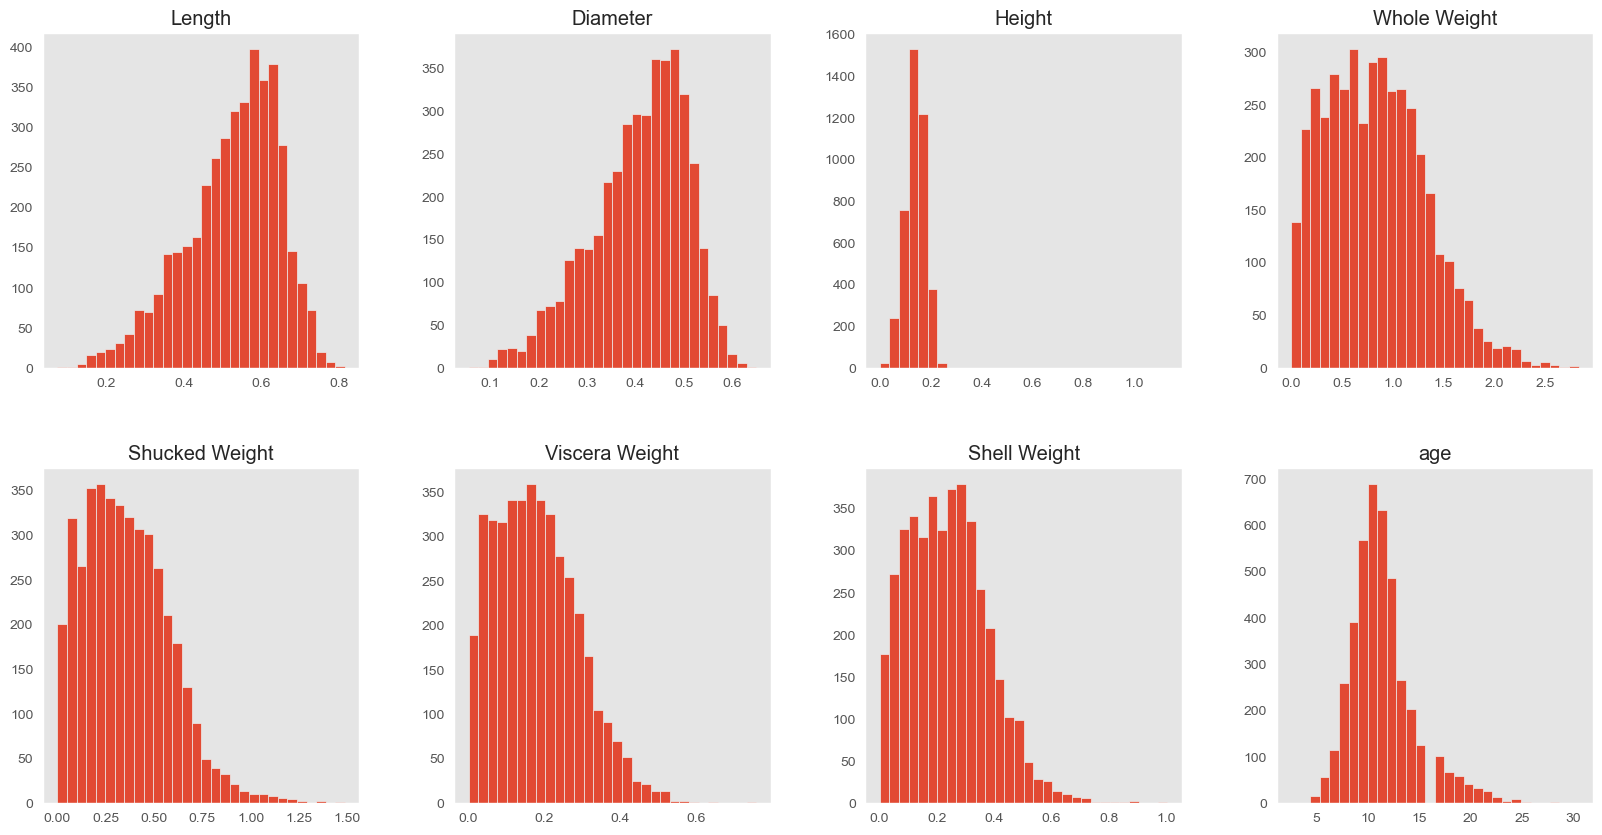

In [8]:
data.hist(figsize=(20,10), grid=False, layout=(2, 4), bins = 30)

In [9]:
numerical_features = data.select_dtypes(include=[np.number]).columns
categorical_features = data.select_dtypes(include=[object]).columns

In [10]:
numerical_features

Index(['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'age'],
      dtype='object')

In [11]:
categorical_features

Index(['Sex'], dtype='object')

In [12]:
skew_values = skew(data[numerical_features], nan_policy = 'omit')
dummy = pd.concat([pd.DataFrame(list(numerical_features), columns=['Features']),
           pd.DataFrame(list(skew_values), columns=['Skewness degree'])], axis = 1)
dummy.sort_values(by = 'Skewness degree' , ascending = False)

,Features,Skewness degree
2,Height,3.127694
7,age,1.113702
4,Shucked Weight,0.718840
6,Shell Weight,0.620704
5,Viscera Weight,0.591640
3,Whole Weight,0.530768
1,Diameter,-0.608979
0,Length,-0.639643


- For normally distributed data, the skewness should be about 0. For unimodal continuous distributions, a skewness value > 0 means that there is more weight in the right tail of the distribution. The function skewtest can be used to determine if the skewness value is close enough to 0, statistically speaking.

<AxesSubplot:xlabel='Sex', ylabel='count'>

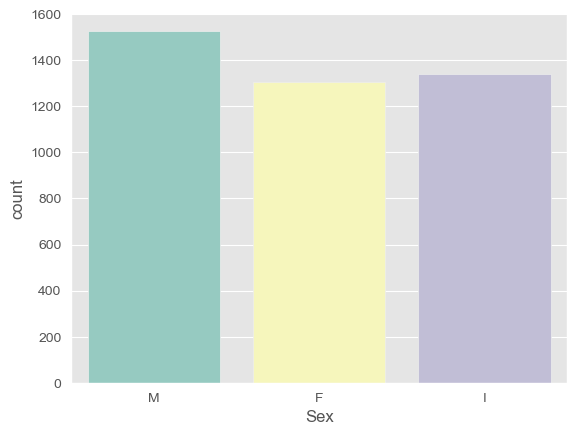

In [13]:
sns.countplot(x = 'Sex', data = data, palette="Set3")

C:\Users\SBK\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 56.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\SBK\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 52.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\SBK\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 58.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Sex', ylabel='age'>

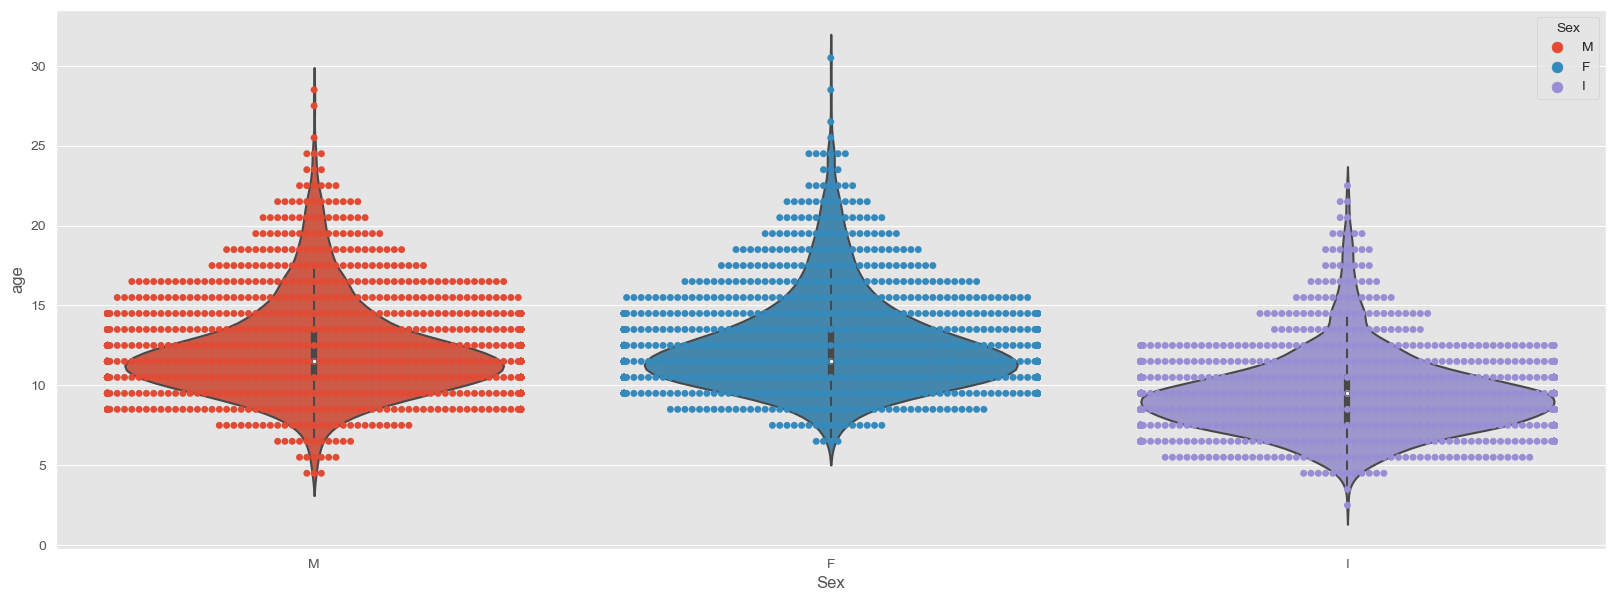

In [14]:
plt.figure(figsize = (20,7))
sns.swarmplot(x = 'Sex', y = 'age', data = data, hue = 'Sex')
sns.violinplot(x = 'Sex', y = 'age', data = data)

key insights length is linearly correlated with diameter while, non-linear relation with height, whole weight, shucked weight, viscera weight and shell weight

<AxesSubplot:>

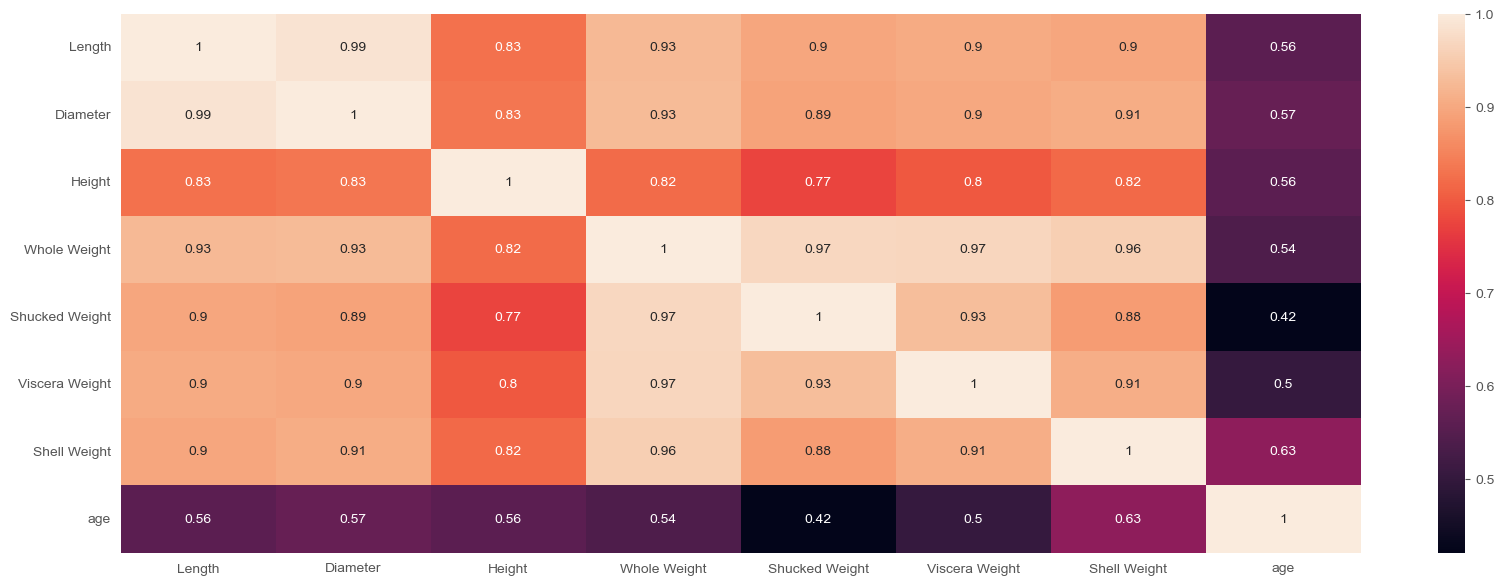

In [15]:
plt.figure(figsize=(20,7))
sns.heatmap(data[numerical_features].corr(), annot=True)

*** Whole Weight is almost linearly varying with all other features except age Heigh has least linearity with remaining features Age is most linearly proprtional with Shell Weight followed by Diameter and length
Age is least correlated with Shucked Weight ***

# Preprocessing Dataset
- I will create label respect to age. Why i need to this because there are to many class if we dont set any range between on age. Age features can take start 3 to 30. That is mean that there are to many class. So that is not meanfull to predict each age. If we build a  regression model may be we can use otherwise in classification it is not enough features to get actual age.
-

In [16]:
for label in "MFI":
    data[label] = data["Sex"] == label
del data["Sex"]

# convert age to age group
for ix in data.index:
    row = data.loc[ix]
    if row.age <= 10.0:
        data.loc[ix, 'age'] = 'young'
    elif row.age >= 13.0:
        data.loc[ix, 'age'] = 'old'
    elif row.age >10.0 and row.age < 13.0:
        data.loc[ix, 'age'] = 'medium'

data.head()

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,age,M,F,I
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,old,True,False,False
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,young,True,False,False
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,medium,False,True,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,medium,True,False,False
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,young,False,False,True


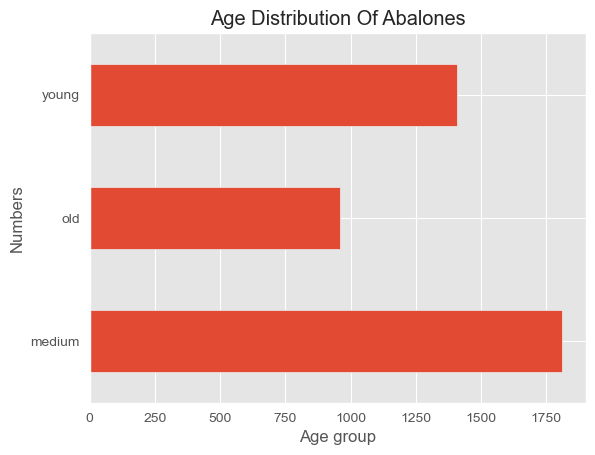

In [17]:
age_group = data.groupby('age').age.count()
ax = age_group.plot(kind='barh')
plt.ylabel('Numbers')
plt.xlabel('Age group')
plt.title('Age Distribution Of Abalones')
plt.show()

## Implement the function “build_dt(X, y, attribute_types, options)”.

In [18]:
def build_dt(X,y,attributes_types,*,options=None):
    minimum_depth = 2
    max_depth = 100
    if  options is not None:
        minimum_depth = options['minimum_depth']
        max_depth = options['max_depth']

    dt = DecisionTree(min_samples_split=minimum_depth,max_depth=max_depth)
    dt.fit(X,y)

    return  dt


## Implement the function “predict_dt(dt, X, options)”.

In [19]:
def predict_dt(dt,X,*,options=None):
    output = dt.predict(X)
    return  output

## Report the performance of your implementation using an appropriate k-fold cross validation  using confusion matrices on the given dataset.

[1 2 3]
1 K-Fold Result
Accuracy: 0.5956937799043063
Precision: 0.6022843544269794
Recall: 0.5956937799043063


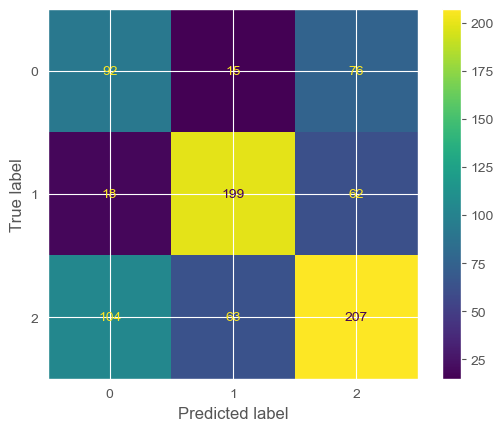

-------------------------------------------------------------
2 K-Fold Result
Accuracy: 0.5849282296650717
Precision: 0.5880477325172694
Recall: 0.5849282296650717


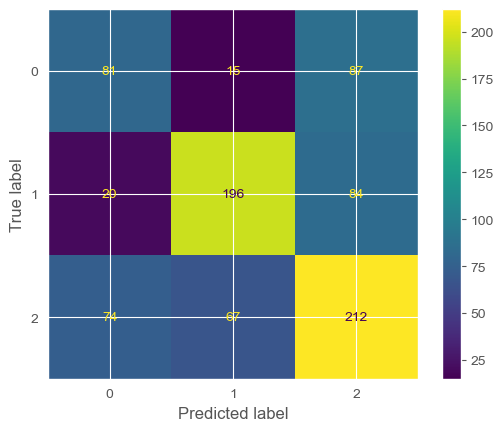

-------------------------------------------------------------
3 K-Fold Result
Accuracy: 0.6119760479041916
Precision: 0.6105622142918348
Recall: 0.6119760479041916


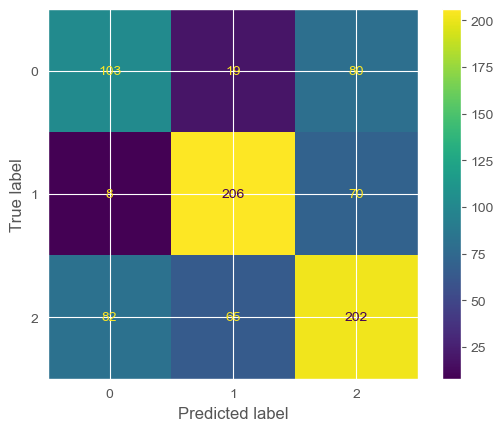

-------------------------------------------------------------
4 K-Fold Result
Accuracy: 0.5892215568862276
Precision: 0.5907401819737149
Recall: 0.5892215568862276


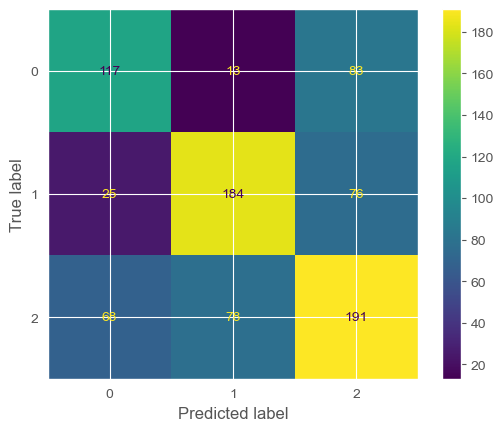

-------------------------------------------------------------
5 K-Fold Result
Accuracy: 0.5976047904191617
Precision: 0.5998252276185422
Recall: 0.5976047904191617


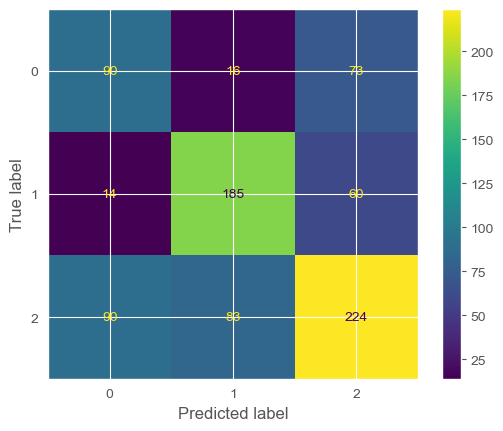

-------------------------------------------------------------


In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score

X = data.drop(columns='age').values.astype(np.float64)
y = data['age'].map({'old':1,'young':2,'medium':3}).values
kf = KFold(n_splits=5,random_state=42,shuffle=True)
n = 1
classes = np.unique(y)
print(classes)
for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        attributes_type = [1 if all(isinstance(arr, np.float64) for arr in X_train) else 0]
        dt = build_dt(X_train,y_train,attributes_types=attributes_type)
        predict_label = predict_dt(dt,X_test)
        cm = confusion_matrix(y_test, predict_label,labels=classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        print(f"{n} K-Fold Result")
        # Calculate accuracy
        accuracy = accuracy_score(y_test, predict_label)

        # Calculate precision
        precision = precision_score(y_test, predict_label,average='weighted')

        # Calculate recall
        recall = recall_score(y_test, predict_label,average='weighted')
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        n = n+1
        disp.plot()
        plt.show()
        print("-------------------------------------------------------------")

## Implement the functions for RandomForest

In [21]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions



In [22]:
def build_rdf(X, y, attribute_types, N):
    rdf = RandomForest(n_trees=N)
    rdf.fit(X,y)
    return  rdf

def predict_rdf(rdf,X):
    predict_label = rdf.predict(X)
    return  predict_label

1 K-Fold Result for RDF
Accuracy: 0.6794258373205742
Precision: 0.6847929185133663
Recall: 0.6794258373205742


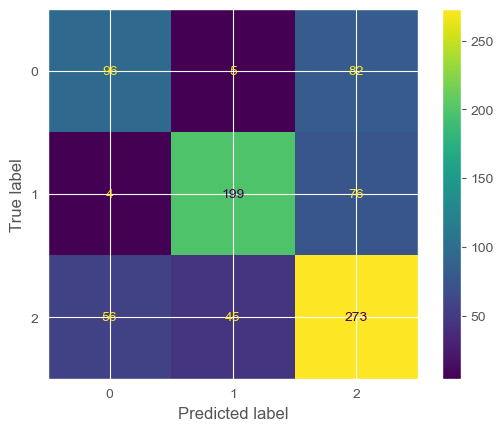

-------------------------------------------------------------
2 K-Fold Result for RDF
Accuracy: 0.6650717703349283
Precision: 0.6756348510134133
Recall: 0.6650717703349283


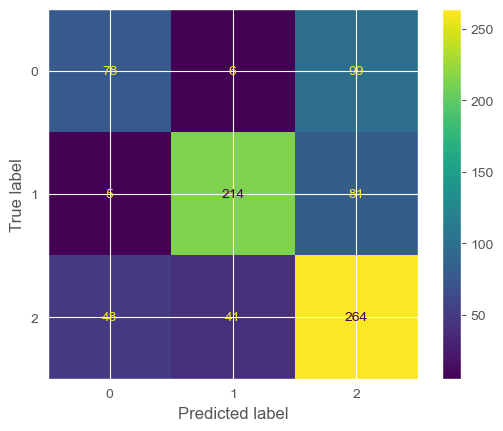

-------------------------------------------------------------
3 K-Fold Result for RDF
Accuracy: 0.6910179640718563
Precision: 0.7059820992518339
Recall: 0.6910179640718563


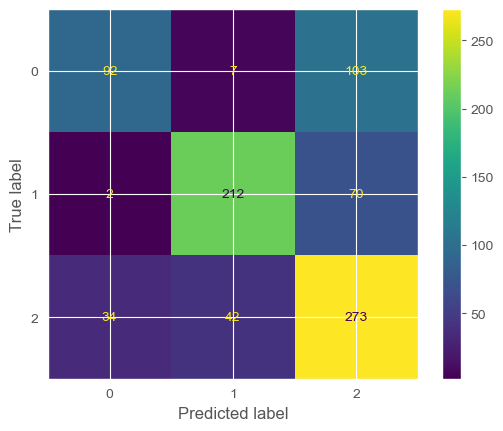

-------------------------------------------------------------
4 K-Fold Result for RDF
Accuracy: 0.651497005988024
Precision: 0.6692347402389637
Recall: 0.651497005988024


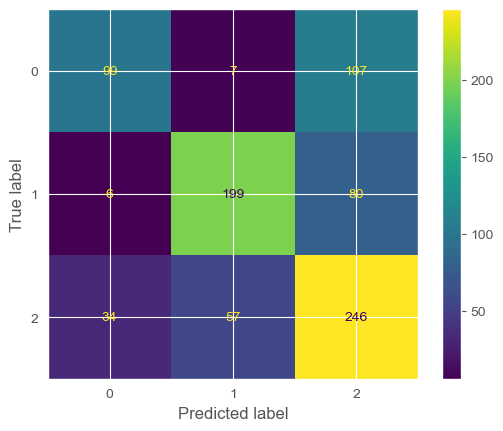

-------------------------------------------------------------
5 K-Fold Result for RDF
Accuracy: 0.6838323353293413
Precision: 0.6848687558564807
Recall: 0.6838323353293413


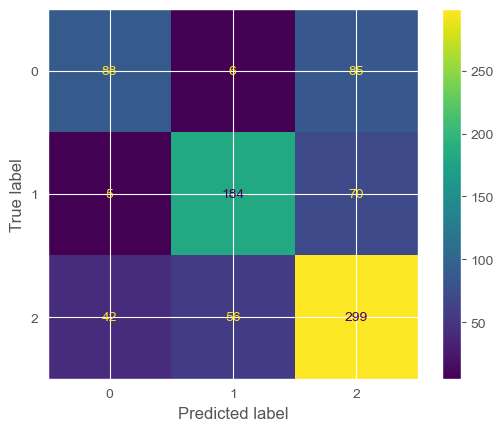

-------------------------------------------------------------


In [23]:
n = 1
for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        attributes_type = [1 if all(isinstance(arr, np.float64) for arr in X_train) else 0]
        dt = build_rdf(X_train,y_train,attribute_types=attributes_type,N=20)
        predict_label = predict_rdf(dt,X_test)
        cm = confusion_matrix(y_test, predict_label,labels=classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        print(f"{n} K-Fold Result for RDF")
        n = n+1
        # Calculate accuracy
        accuracy = accuracy_score(y_test, predict_label)

        # Calculate precision
        precision = precision_score(y_test, predict_label,average='weighted')

        # Calculate recall
        recall = recall_score(y_test, predict_label,average='weighted')
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        disp.plot()
        plt.show()
        print("-------------------------------------------------------------")